In [1]:
# fmt: off
from Interpretability.ModelAugmentation import *
from Interpretability.InterpretabilityMethods import *
from SequentialLearning.SequentialTasks.CIFAR10ClassificationTask import CIFAR10ClassificationTask
from SequentialLearning.EWC_Methods.EWC_Methods import *

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf
# fmt: on
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
MODEL_SAVE_PATH = "models/fashion_mnist_intepretability_model"
LOAD_MODEL = True
TRAIN_MODEL = not LOAD_MODEL

task_labels = [0,1]
epochs = 5
training_batches = 300
validation_batches = 100
batch_size = 32
ewc_method = EWC_Method.FISHER_MATRIX

# Model Training and Architecture

In [3]:
model: tf.keras.Model
if LOAD_MODEL and os.path.exists(MODEL_SAVE_PATH):
    # Try to load model directly, if one exists
    print("LOADING MODEL")
    model = tf.keras.models.load_model(MODEL_SAVE_PATH)  # type: ignore
else:
    # Otherwise, make an entire new model!
    print("CREATING MODEL")
    model_input_shape = (32,32,3)
    model_inputs = model_layer = tf.keras.Input(shape=model_input_shape)
    model_layer = tf.keras.layers.Conv2D(12, (5,5), activation="relu", name="conv2d_1")(model_layer)
    model_layer = tf.keras.layers.MaxPool2D((2,2))(model_layer)
    model_layer = tf.keras.layers.Conv2D(12, (3,3), activation="relu", name="conv2d_2")(model_layer)
    model_layer = tf.keras.layers.Conv2D(9, (3,3), activation="relu", name="conv2d_3")(model_layer)
    model_layer = tf.keras.layers.Flatten()(model_layer)
    model_layer = tf.keras.layers.Dense(10, activation="relu")(model_layer)
    model_layer = tf.keras.layers.Dense(len(task_labels))(model_layer)

    model = tf.keras.Model(inputs=model_inputs, outputs=model_layer, name="base_model")

if len(task_labels) == 2:
    loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
else:
    loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model.summary()

LOADING MODEL
Model: "base_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 12)        912       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 12)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 12)        1308      
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 9)         981       
                                                                 
 flatten (Flatten)           (None, 900)               0         
                                          

In [4]:
task = CIFAR10ClassificationTask(
        name=f"Task 0",
        model=model,
        model_base_loss=loss_fn,
        task_labels=task_labels,
        training_batches = training_batches,
        validation_batches = validation_batches,
        batch_size=batch_size
    )
ewc_term_creator = EWC_Term_Creator(ewc_method, model, [task])

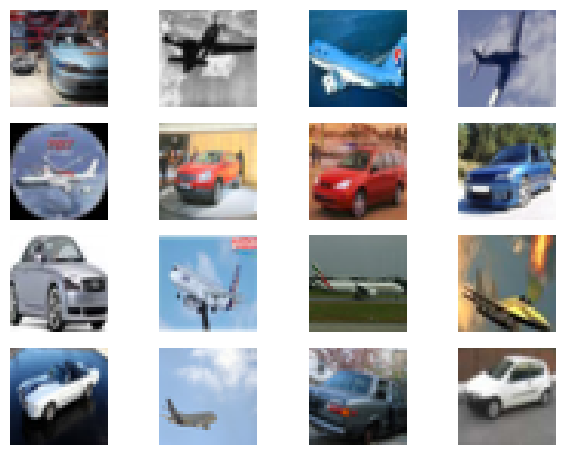

In [5]:
# Show some images from the task dataset
data = task.validation_dataset.take(1)
data_images, data_labels = data.as_numpy_iterator().next()
data_images = data_images[:16]
data_labels = data_labels[:16]
plot_images(data_images)

In [6]:
if TRAIN_MODEL:
    checkpoint_path = MODEL_SAVE_PATH+"/checkpoint"
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        verbose=1)
    history = task.train_on_task(epochs=epochs, callbacks=[
#         checkpoint_callback, 
        *ewc_term_creator.callback_dict.values(),
    ])
    model.save(MODEL_SAVE_PATH)
else:
    print(f"{TRAIN_MODEL=}")
ewc_term = ewc_term_creator.create_term(ewc_lambda = 1)

TRAIN_MODEL=False
--------------------------------------------------------------------------------
STARTING FISHER CALCULATION
FINISHED FISHER CALCULATION
--------------------------------------------------------------------------------


In [7]:
threshold_model = threshold_model_by_omega(task.model, ewc_term.omega_matrix, 
    threshold_percentage = 0.2,
    comparison_method = ComparisonMethod.LAYER_WISE,
    aggregation_level = AggregationLevel.NO_AGGREGATION,
    aggregation_method = AggregationMethod.MEAN_AVERAGE,
)

LAYER_WISE layer_index=1 conv2d_1 threshold_value=86015.13
LAYER_WISE layer_index=3 conv2d_2 threshold_value=3232.2578
LAYER_WISE layer_index=4 conv2d_3 threshold_value=12816.524
LAYER_WISE layer_index=6 dense threshold_value=0.0
LAYER_WISE layer_index=7 dense_1 threshold_value=0.0


## Validation Testing

In [8]:
print(f"ORIGINAL  MODEL: {task.model.evaluate(task.validation_dataset, steps=task.validation_batches, return_dict=True)}")
print(f"THRESHOLD MODEL: {threshold_model.evaluate(task.validation_dataset, steps=task.validation_batches, return_dict=True)}")

100/100 [==============================] - 2s 10ms/step - loss: 0.2151 - base_loss: 0.2151
ORIGINAL  MODEL: {'loss': 0.21508334577083588, 'base_loss': 0.21508334577083588}
100/100 [==============================] - 2s 8ms/step - loss: 0.3286
THRESHOLD MODEL: {'loss': 0.3286277651786804}


# Interpretability Methods

## Kernel Inspection

In [26]:
kernel_inspection(model=task.model, steps=1000, step_size=0.01, layer_name="conv2d_1")
# kernel_inspection(model=task.model, steps=100, step_size=0.05, layer_name="conv2d_2")
# kernel_inspection(model=task.model, steps=100, step_size=0.05, layer_name="conv2d_3")

OPERATING ON conv2d_1


In [ ]:
kernel_inspection(model=threshold_model, steps=100, step_size=0.05, layer_name="conv2d_1")
# kernel_inspection(model=threshold_model, steps=100, step_size=0.05, layer_name="conv2d_2")
# kernel_inspection(model=threshold_model, steps=100, step_size=0.05, layer_name="conv2d_3")

## Occlusion Sensitivity

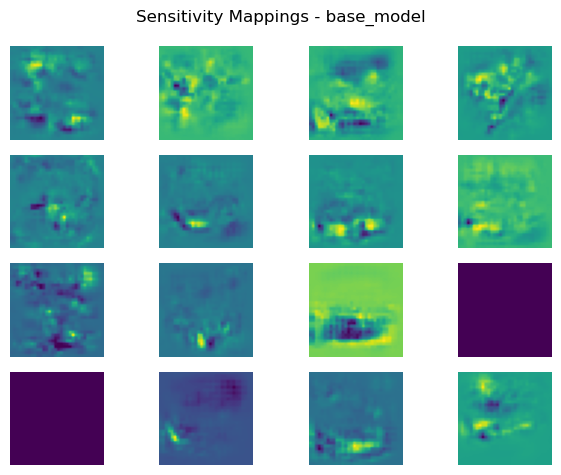

In [11]:
occlusion_sensitivity(task.model, data_images, data_labels, patch_size=2, stride=1)

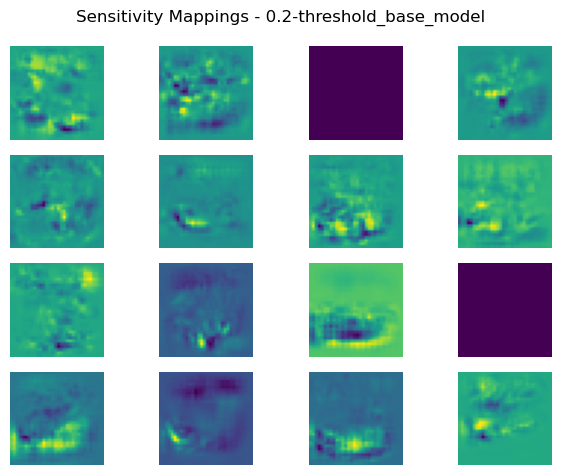

In [12]:
occlusion_sensitivity(threshold_model, data_images, data_labels, patch_size=2, stride=1)

## GRADCAM

HEATMAP RANGE (EXTREME): 0.19615840911865234
HEATMAP RANGE (AVG): 0.12911733984947205


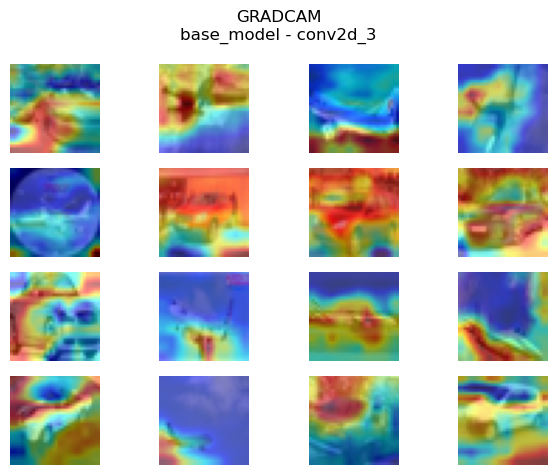

In [23]:
GRADCAM(task.model, data_images, data_labels, layer_name="conv2d_3",
    alpha=0.5, beta=0.5,
    show_predictions=0, absolute_scale=None)

HEATMAP RANGE (EXTREME): 0.2144506573677063
HEATMAP RANGE (AVG): 0.1484977900981903


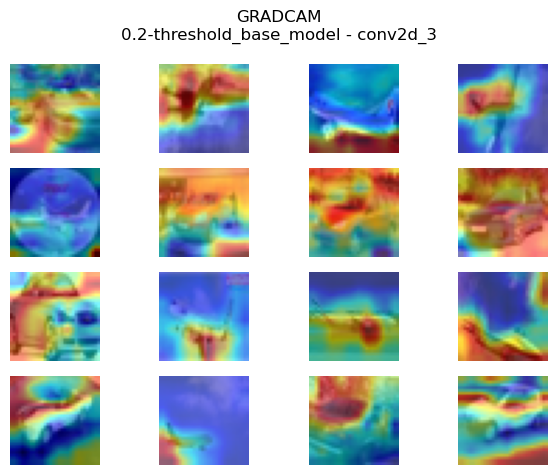

In [14]:
GRADCAM(threshold_model, data_images, data_labels, layer_name="conv2d_3", show_predictions=0, absolute_scale=None)